# PCA meets RG

In this project, I want to go through Principal Component Analyis (PCA), its relationship to the Renormalisation Group (RG), and hopefully visually aspects of this using a data-set of faces.

I have already made a Colab notebook on PCA, which is [here](https://colab.research.google.com/drive/1buuvuHPqJdeyk-tITETFGTHaL2W-zBzj).

This project is inspired by this [paper](https://arxiv.org/pdf/1610.09733.pdf). 

In [5]:
import numpy as np
import scipy.stats as stats
import math
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('face_data.csv')
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
395,0.400826,0.495868,0.570248,0.632231,0.648760,0.640496,0.661157,0.636364,0.665289,0.698347,...,0.396694,0.264463,0.099174,0.181818,0.243802,0.247934,0.161157,0.157025,0.136364,39
396,0.367769,0.367769,0.351240,0.301653,0.247934,0.247934,0.367769,0.512397,0.574380,0.628099,...,0.334711,0.289256,0.285124,0.338843,0.404959,0.458678,0.487603,0.512397,0.549587,39
397,0.500000,0.533058,0.607438,0.628099,0.657025,0.632231,0.657025,0.669422,0.673554,0.702479,...,0.148760,0.152893,0.161157,0.161157,0.173554,0.157025,0.177686,0.148760,0.190083,39
398,0.214876,0.219008,0.219008,0.223140,0.210744,0.202479,0.276859,0.400826,0.487603,0.549587,...,0.392562,0.367769,0.409091,0.479339,0.524793,0.545455,0.574380,0.590909,0.603306,39
399,0.516529,0.462810,0.280992,0.252066,0.247934,0.367769,0.574380,0.615702,0.661157,0.615702,...,0.264463,0.293388,0.301653,0.293388,0.322314,0.322314,0.359504,0.355372,0.384298,39


In [7]:
# Each of the 400 observations is a 64x64 image belonging to 1 of 40 classes
print("Shape:",df.shape)
print("Classes:",df['target'].nunique())

Shape: (400, 4097)
Classes: 40


We have the matrix $\textbf{X}\in \mathbb{R}^{400\times4096}$ which consists of 400 observations each with 4096 'features'. These features are the $64\times 64$ pixel grids. 

In [8]:
X = np.array(df.drop('target', axis=1))

In [9]:
means = np.mean(X,axis=0,keepdims=True)
sds = np.std(X,axis=0,keepdims=True)

In [10]:
# Normalise data
mean_mat = np.ones((400,1))@np.mean(X,axis=0,keepdims=True)
sd_mat = np.ones((400,1))@np.std(X,axis=0,keepdims=True)

X_std = (X-mean_mat)/sd_mat

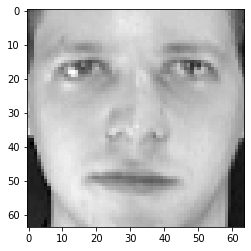

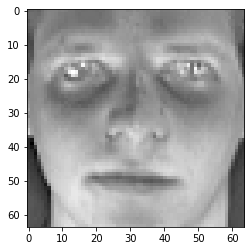

In [11]:
# How to plot an image
plt.imshow(X[0].reshape(64,64),cmap="gray")
plt.show()
plt.imshow(X_std[0].reshape(64,64),cmap="gray") # standardised
plt.show()

As we can see, plotting the normalised data gives us pretty creepy faces. We thus define a function that un-normalises the data.

In [12]:
def plot_untransform(im):
    untrans = (im*sds) + means
    plt.imshow(untrans.reshape(64,64),cmap="gray") 
    plt.show()

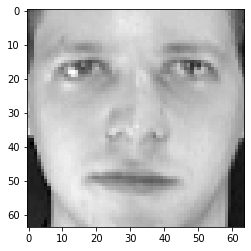

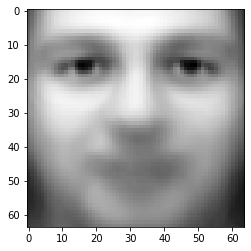

In [13]:
plot_untransform(X_std[0])
plt.imshow(means.reshape(64,64),cmap="gray") 
plt.show()

We calculate the covariance matrix of the normalised data, and then determine the eigenvectors and eigenvalues. We can then visualise the various eigenvectors. 

In [14]:
# Work out covariance matrix (we do not scale it by 1/(N-1) )
cov_mat = X_std.T.dot(X_std)
cov_mat.shape

(4096, 4096)

In [15]:
# We investigate the relationship between the eigendecomposition and SVD
ex = np.array([[2,1],[1,3],[0,2]])

# The SVD is:
U, S, V = np.linalg.svd(ex) 
print("SVD",U,S,V,sep="\n")

# The eigendecomposition of the covariance is: 
ex_cov = ex.T@ex
eig_vals, eig_vecs = np.linalg.eig(ex_cov)
print("Eigendecomp",eig_vals,eig_vecs,sep="\n")

SVD
[[-0.42876596  0.85280177  0.2981424 ]
 [-0.78131631 -0.18436179 -0.59628479]
 [-0.45354666 -0.48861014  0.74535599]]
[4.02825173 1.66528916]
[[-0.40683858 -0.91350006]
 [ 0.91350006 -0.40683858]]
Eigendecomp
[ 2.77318798 16.22681202]
[[-0.91350006 -0.40683858]
 [ 0.40683858 -0.91350006]]


By reading the documentation, (type `np.linalg.eig?`), I see that the eigenvectors returned by `np.linalg.eig` are not sorted by eigenvalue, whereas the singular values returned by `np.linalg.svd` are arranged in descending order. 

In [16]:
# Do SVD of original matrix
U, S, V = np.linalg.svd(X_std) 

In [17]:
print(U.shape)
print(S.shape)
print(V.shape)

(400, 400)
(400,)
(4096, 4096)


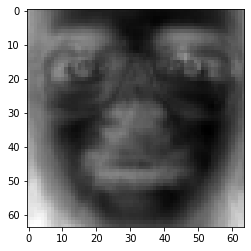

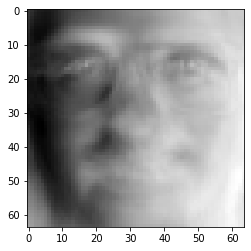

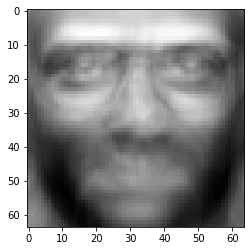

In [18]:
# Plot the first few eigenvectors
for i in range(3):
    plt.imshow(V[i].reshape(64,64),cmap="gray")
    plt.show()

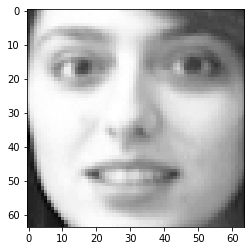

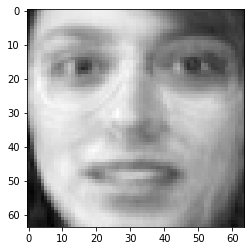

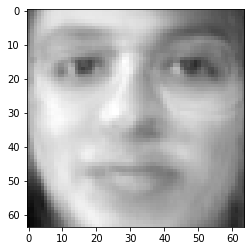

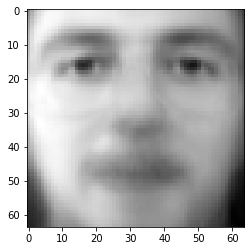

In [19]:
for modes in [400,100,25,3]:
    face = U[70,:modes]@np.diag(S[:modes])@V[:modes,:]
    plot_untransform(face)

# RG inspired analysis
We start by examinging the spectrum of the eigenvalues. This is the squared singular values.

In [20]:
eig_vals = S*S  # get eigenvalues 
eig_vals = [0 if val < 1e-1 else val for val in eig_vals]  # set small eig_vals to 0

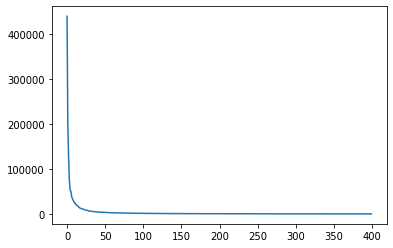

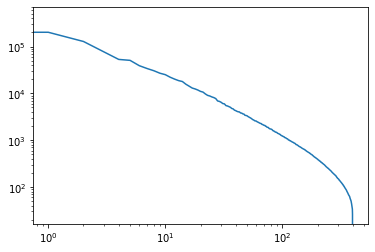

In [21]:
plt.plot(eig_vals)
plt.show() #normal scale
plt.plot(eig_vals)
plt.yscale("log")
plt.xscale("log")
plt.show() #log scale

How does this compare to randomly generated data drawn from a Gaussian? 

In [22]:
np.random.rand(*X.shape)

array([[0.92563575, 0.45821764, 0.616854  , ..., 0.92820944, 0.52322298,
        0.00904652],
       [0.1656391 , 0.59998851, 0.11320231, ..., 0.44535474, 0.94147229,
        0.76069162],
       [0.49328312, 0.302869  , 0.99309727, ..., 0.01892803, 0.89360175,
        0.89726824],
       ...,
       [0.70796576, 0.44062601, 0.8063142 , ..., 0.15902463, 0.69879722,
        0.82042075],
       [0.26223064, 0.77203221, 0.72192714, ..., 0.77665757, 0.35321882,
        0.21743865],
       [0.48231671, 0.37881027, 0.45179632, ..., 0.41937598, 0.67952772,
        0.41780089]])

In [23]:
rnd_data = np.random.normal(size=X.shape) #random normal data

_, S_rand, _ = np.linalg.svd(rnd_data)  # get singular value decomposition of random data

In [24]:
np.linspace?

The paper talks about the fractional rank. I hypothesize that this is the fraction of eigenvalues that are greater than a given value. So, if we have a list of eigenvalues in descending order:
$[5,4,3,2,1]$, the corrsponding fractional ranks would be:
$[0,0.2,0.4,0.6,0.8,1]$. Perhaps a less confusing way of thinking about this is that we are assigning each eigenvalue a number from 0 to 1 and the largest eigenvalue gets given 0 and the smallest gets given 1. 

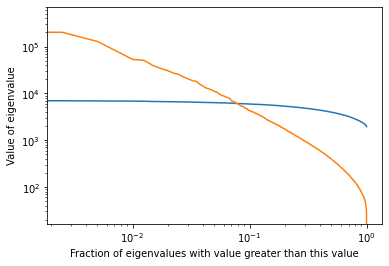

In [25]:
x = np.linspace(0,1,400) #fractional rank
rand_eig_vals = S_rand*S_rand # get eigenvalues 
rand_eig_vals = [0 if val < 1e-1 else val for val in rand_eig_vals] # set small eig_vals to 0
plt.plot(x,rand_eig_vals)
plt.plot(x,eig_vals)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Value of eigenvalue")
plt.xlabel("Fraction of eigenvalues with value greater than this value")
plt.show()

Next, we want to see what happens as we coarse-grain the system by projecting the data onto fewer and fewer eigenmodes, replacing each variable $\phi_i$ by an average over low variance details . We condsider the average normalised fourth order moments across all of the variables (in this case the pixels) as we coarse-grain our system. 

In [26]:
modes = np.arange(100,401,10)
kurts = [] # kurtosis for each variable at different levels of coarse graining

for n in modes:
    coarse_data = U[:,:n]@np.diag(S[:n])@V[:n,:]
    kurts.append(stats.kurtosis(coarse_data,axis=0)) # works out the normalised 4th order moment for each of the 4096 variables


In [27]:
mean_kurts = [np.mean(var) for var in kurts]
sd_kurts = [np.std(var) for var in kurts]

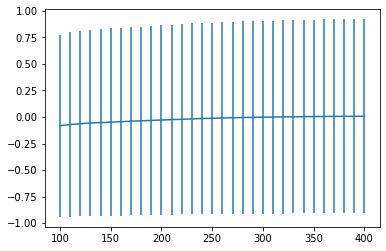

In [28]:
plt.errorbar(modes,mean_kurts, sd_kurts)
plt.show()